# make movie of drifter pairs

In [1]:
import os
from glob import glob

from dask.distributed import Client
from dask import delayed
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.drifters as edr
import mitequinox.plot as epl

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=12, walltime='12:00:00', memory='60GB')
#cluster = PBSCluster(cores=1, walltime='01:00:00', memory='20GB')
w = cluster.scale(4*12) # postprocessing

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "
/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [3]:
# get dask handles and check dask server status
client = Client(cluster)
#client = Client()

In [4]:
cluster

---

## load data

In [5]:
ncfiles = glob(edr.dr_data_dir+'pairs_tfilt/low_inertial_*.nc')
print('%d files'%len(ncfiles))
i=0
#ds = xr.open_mfdataset(ncfiles[i:i+100], concat_dim='index', parallel=True)
ds = xr.open_mfdataset(ncfiles, concat_dim='index', parallel=True)
print('Dataset size = %.1f GB '%(ds.nbytes/1e9))
#
ds = ds.set_coords(['pair','t0'])

4715 files
Dataset size = 85.9 GB 


In [6]:
def drop(ds, ndrop):
    vdrop = list(ds)
    for v in ndrop:
        vdrop.remove(v)
    return ds.drop(vdrop)

In [7]:
ndrop = []
#ndrop += ['pair']
ndrop += ['v%d_0'%d for d in range(3)]
ndrop += ['v%d_1'%d for d in range(3)]
ndrop += [v+'_'+d for v in ['GPS','DROGUE'] for d in ['0','1']]
#
ndrop += [v+'_'+d for v in ['U','V','LON','LAT'] for d in ['0','1']]
ndrop += [v+'_'+d+'_low' for v in ['U','V', 'v0', 'v1', 'v2'] for d in ['0','1']]
ndrop += [v+'_'+d+'_inertial' for v in ['U','V'] for d in ['0','1']]
#
ndrop

ds = drop(ds,ndrop)
print('Dataset size = %.1f GB '%(ds.nbytes/1e9))
ds

Dataset size = 34.8 GB 


<xarray.Dataset>
Dimensions:       (TIME: 721, index: 188590)
Coordinates:
  * TIME          (TIME) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 00:00:00
    pair          (index) object dask.array<shape=(188590,), chunksize=(40,)>
    t0            (index) datetime64[ns] dask.array<shape=(188590,), chunksize=(40,)>
Dimensions without coordinates: index
Data variables:
    LAT_0         (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(40, 721)>
    LON_0         (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(40, 721)>
    U_0           (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(40, 721)>
    V_0           (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(40, 721)>
    DROGUE_0      (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(40, 721)>
    GPS_0         (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(40, 721)>
    v0_0          (index, TIME) float64 dask.array<shape=(188590, 721

In [8]:
ds = ds.persist()

In [9]:
#ds = ds.drop('pair') # try to see if this breaks stacking further below
ds = ds.chunk({'index': 400})
ds.to_zarr(edr.dr_data_dir+'pairs_tfilt/low_inertial.zarr', mode='w')
#ds.to_zarr(edr.dr_data_dir+'pairs_tfilt/low_inertial_GPS.zarr', mode='w')

/home/mp/pontea/.conda/envs/equinox/lib/python3.6/site-packages/xarray/conventions.py:172: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  SerializationWarning)


---

## open zarr archive

In [5]:
ds = xr.open_zarr(edr.dr_data_dir+'pairs_tfilt/low_inertial.zarr')
print('%d pair indexes' %ds.index.size)

188590 pair indexes


In [6]:
ds

<xarray.Dataset>
Dimensions:       (TIME: 721, index: 188590)
Coordinates:
  * TIME          (TIME) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 00:00:00
    pair          (index) object dask.array<shape=(188590,), chunksize=(23574,)>
    t0            (index) datetime64[ns] dask.array<shape=(188590,), chunksize=(47148,)>
Dimensions without coordinates: index
Data variables:
    DROGUE_0      (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    DROGUE_1      (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    GPS_0         (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    GPS_1         (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    LAT_0         (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    LAT_1         (index, TIME) float64 dask.array<shape=(188590, 721), chunksize=(400, 721)>
    LON_0         (index, TIME) float64 dask.array<shape=

In [7]:
# recompute lon/lat, add central point information
for v in range(3):
    ds['v%d_mid'%v] = (ds['v%d_0'%v]+ds['v%d_1'%v])*.5

for i in ['0','1']:
    ds = (edr.compute_lonlat(ds, v0='v0_'+i, v1='v1_'+i, v2='v2_'+i, 
                                    lon_key='LON_'+i, lat_key='LAT_'+i, dropv=False))
    ds = (edr.compute_lonlat(ds, v0='v0_'+i+'_low', v1='v1_'+i+'_low', v2='v2_'+i+'_low', 
                                    lon_key='LON_'+i+'_low', lat_key='LAT_'+i+'_low', dropv=False))

ds = (edr.compute_lonlat(ds, v0='v0_mid', v1='v1_mid', v2='v2_mid', 
                         lon_key='LON_mid', lat_key='LAT_mid', dropv=False))

ds['r'] = edr.haversine(ds.LON_0, ds.LAT_0, ds.LON_1, ds.LAT_1)

In [8]:
# narrow down to GPS data
ds = ds.where( (ds.isel(TIME=0).GPS_0==1) & (ds.isel(TIME=0).GPS_1==1) , drop=True)
ds

<xarray.Dataset>
Dimensions:       (TIME: 721, index: 33071)
Coordinates:
  * TIME          (TIME) timedelta64[ns] 00:00:00 01:00:00 ... 30 days 00:00:00
    pair          (index) object dask.array<shape=(33071,), chunksize=(3468,)>
    t0            (index) datetime64[ns] dask.array<shape=(33071,), chunksize=(7589,)>
Dimensions without coordinates: index
Data variables:
    DROGUE_0      (index, TIME) float64 dask.array<shape=(33071, 721), chunksize=(15, 721)>
    DROGUE_1      (index, TIME) float64 dask.array<shape=(33071, 721), chunksize=(15, 721)>
    GPS_0         (index, TIME) float64 dask.array<shape=(33071, 721), chunksize=(15, 721)>
    GPS_1         (index, TIME) float64 dask.array<shape=(33071, 721), chunksize=(15, 721)>
    LAT_0         (index, TIME) float64 dask.array<shape=(33071, 721), chunksize=(15, 721)>
    LAT_1         (index, TIME) float64 dask.array<shape=(33071, 721), chunksize=(15, 721)>
    LON_0         (index, TIME) float64 dask.array<shape=(33071, 721), chu

In [9]:
# rechunk
ds = ds.chunk({'index': 300})
ds0 = ds

---
## derives basic statistics: 

- near-inertial and low-frequency averaged energies

- averaged locations

In [10]:
ds = ds0.persist()

In [11]:
for b in ['inertial','low']:
    ds['KE0_'+b] = ds['U_0_'+b]**2+ds['V_0_'+b]**2
    ds['KE1_'+b] = ds['U_1_'+b]**2+ds['V_1_'+b]**2

In [12]:
ds_mean = ds.mean('TIME').chunk({'index':1e4})
ds_mean = (edr.compute_lonlat(ds_mean, v0='v0_0', v1='v1_0', v2='v2_0', \
                              lon_key='LON_0', lat_key='LAT_0', dropv=False))
ds_mean = (edr.compute_lonlat(ds_mean, v0='v0_1', v1='v1_1', v2='v2_1', \
                              lon_key='LON_1', lat_key='LAT_1', dropv=False))

In [13]:
ds_mean = ds_mean.persist()

(array([2758., 5298., 4240., 2862., 2216., 1843., 1524., 1537., 1062.,
        1049.,  840.,  772.,  704.,  601.,  532.,  438.,  380.,  265.,
         283.,  213.,  195.,  209.,  155.,  161.,  162.,  146.,  172.,
         110.,   96.,  122.,  109.,   83.,   77.,   66.,   76.,   90.,
          72.,   68.,   86.,   76.]),
 array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
        0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
        0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
        0.027, 0.028, 0.029, 0.03 , 0.031, 0.032, 0.033, 0.034, 0.035,
        0.036, 0.037, 0.038, 0.039, 0.04 ]),
 <a list of 40 Patch objects>)

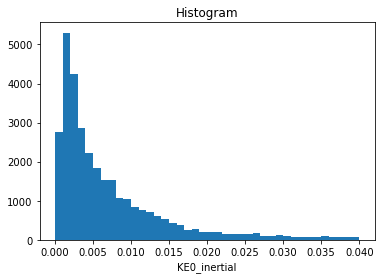

In [14]:
ds_mean.KE0_inertial.plot.hist(bins=np.arange(0,.2**2,1e-3))

(array([1609., 2090., 2222., 2420., 2445., 2733., 3196., 4070., 5242.,
        7044.]),
 array([1.38990288e-03, 5.00012400e+01, 1.00001090e+02, 1.50000940e+02,
        2.00000790e+02, 2.50000640e+02, 3.00000490e+02, 3.50000340e+02,
        4.00000191e+02, 4.50000041e+02, 4.99999891e+02]),
 <a list of 10 Patch objects>)

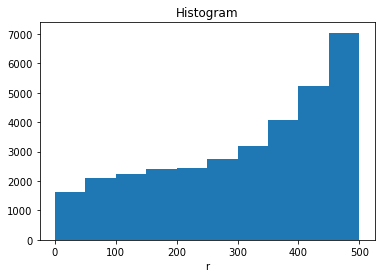

In [15]:
ds_mean.r.plot.hist()

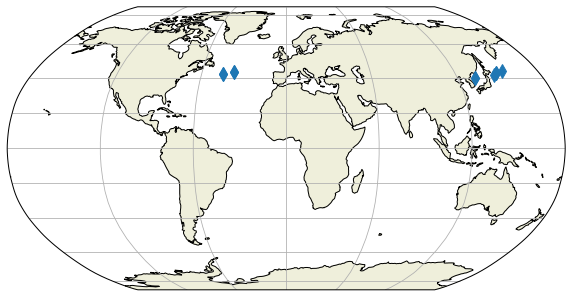

In [16]:
ke_threshold = 0.02
r_band = [50,150]
lat_band = [35,45]

lds = ds_mean.where( (ds_mean.KE0_inertial>ke_threshold) & (ds_mean.KE1_inertial>ke_threshold), drop=True )
lds = lds.where( (lds.r>r_band[0]) & (lds.r<r_band[1]), drop=True )
lds = lds.where( (lds.LAT_mid>lat_band[0]) & (lds.LAT_mid<lat_band[1]), drop=True)

_projection = ccrs.Robinson()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=_projection)
ax.set_global()
ax.coastlines('110m')
ax.plot(lds.LON_mid.values.squeeze(), lds.LAT_mid.values.squeeze(), 'd', ms=10, transform=ccrs.PlateCarree())
ax.gridlines()
ax.add_feature(cfeature.LAND)

In [17]:
def get_pairs(ds, ke_threshold, r_band, lat_band=None):
    lds = ds.where( (ds.KE0_inertial>ke_threshold) & (ds.KE1_inertial>ke_threshold), drop=True)
    lds = lds.where( (lds.r>r_band[0]) & (lds.r<r_band[1]), drop=True )
    if lat_band is not None:
        lds = lds.where( (lds.LAT_mid>lat_band[0]) & (lds.LAT_mid<lat_band[1]), drop=True)
    print('%d pair indexes' %lds.index.size)
    return lds.pair.values

In [18]:
pairs = get_pairs(ds_mean, .02, [50,150], lat_band=[35,45])

10 pair indexes


In [19]:
pairs

array(['63947920-63947860', '62419660-62419650', '62419650-62419660',
       '63948570-63948740', '62328990-62328430', '62328430-62328990',
       '63947860-63947920', '63948740-63948570', '62414600-63894710',
       '63949830-64821340'], dtype=object)

'/work/ALT/swot/aval/syn/drifters/figs/63948740-63948570_t00000.png'

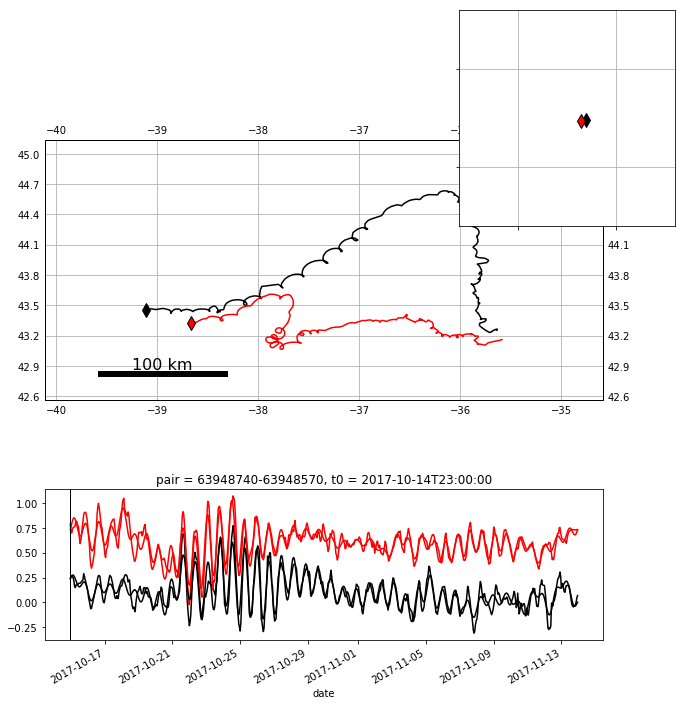

In [22]:
# could delete all figures beforehand
figdir = edr.dr_data_dir+'figs/'
#print('Figures directory: '+figdir)

cols = ['k','r']

def genfig(ds, i, dlon=1, dlat=.5, overwrite=True, offline=True, print_fig=True):
    
    if offline:
        plt.switch_backend('agg')
    
    ds = ds.assign_coords(date = xr.DataArray(ds.t0.values+ds.TIME.values, coords=[ds.TIME]))
    dsi = ds.isel(TIME=i)
    
    fig = plt.figure(figsize=(10,10))
    grid = plt.GridSpec(3, 1, wspace=0.4, hspace=0.3)
    
    ax = plt.subplot(grid[2, :])
    off1 = .5
    ds.U_0.plot(ax=ax, x='date', color=cols[0])
    (off1+ds.U_1).plot(ax=ax, x='date', color=cols[1])
    (ds.U_0_inertial+ds.U_0_low).plot(ax=ax, x='date', color=cols[0])
    (off1+ds.U_1_inertial+ds.U_1_low).plot(ax=ax, x='date', color=cols[1])
    ax.axvline(x=dsi.date.values, color='k', lw=1)
    
    ax = plt.subplot(grid[:2, :], projection=ccrs.PlateCarree())    
    hextent = [min(ds.LON_0.min().values,ds.LON_1.min().values)-dlon, 
               max(ds.LON_0.max().values,ds.LON_1.max().values)+dlon,
               min(ds.LAT_0.min().values,ds.LAT_1.min().values)-dlat, 
               max(ds.LAT_0.max().values,ds.LAT_1.max().values)+dlat]
    ax.set_extent(hextent, crs=ccrs.PlateCarree())
    
    ax.plot(ds.LON_0.values.squeeze(), ds.LAT_0.values.squeeze(), color=cols[0], transform=ccrs.PlateCarree())
    ax.plot(ds.LON_1.values.squeeze(), ds.LAT_1.values.squeeze(), color=cols[1], transform=ccrs.PlateCarree())
    #plt.gca().set_prop_cycle(None)
    ax.plot(dsi.LON_0, dsi.LAT_0, marker='d', ms=10, 
            markeredgecolor='k', markerfacecolor=cols[0], transform=ccrs.PlateCarree())
    ax.plot(dsi.LON_1, dsi.LAT_1, marker='d', ms=10, 
            markeredgecolor='k', markerfacecolor=cols[1], transform=ccrs.PlateCarree())
    ax.coastlines('50m')
    
    #ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())
    #ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
    #lon_formatter = LongitudeFormatter(zero_direction_label=True)
    #lat_formatter = LatitudeFormatter()
    #ax.xaxis.set_major_formatter(lon_formatter)
    #ax.yaxis.set_major_formatter(lat_formatter)
        
    epl.scale_bar(ax, location=(.1,.1), length=100, linewidth=6, text_kwargs={'fontsize':16})
    
    ax.gridlines(draw_labels=True)
    
    ax = plt.axes([.7, .7, .3, .3])
    sc_lon = np.sin(np.pi/180.*dsi.LON_mid.values)
    yticks = [-10/111., 10/111.]
    ax.set_xticks([t*sc_lon for t in yticks])
    ax.set_yticks(yticks)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    #ax.plot((ds.LON_0-ds.LON_0_low).values.squeeze(), (ds.LAT_0-ds.LAT_0_low).values.squeeze(), 
    #        color='.5')
    ax.plot((dsi.LON_0-dsi.LON_0_low).values, (dsi.LAT_0-dsi.LAT_0_low).values, 
            'd', markerfacecolor=cols[0], markeredgecolor='k', ms=10)
    ax.plot((dsi.LON_1-dsi.LON_1_low).values, (dsi.LAT_1-dsi.LAT_1_low).values, 
            'd', markerfacecolor=cols[1], markeredgecolor='k', ms=10)
    lat_lim = .2
    ax.set_xlim([-lat_lim*sc_lon,lat_lim*sc_lon])
    ax.set_ylim([-lat_lim,lat_lim])
    ax.grid()
    
    figname = figdir+'%s_t%05d' %(ds.pair.values[0], i)+'.png'
    #
    #if not os.path.isfile(figname) or overwrite:
    fig.savefig(figname)
    if offline:
        plt.close()
        
    return figname

lds = ds.where(ds.pair==pairs[7], drop=True)
genfig(lds, 0, offline=False, print_fig=False)

In [101]:
# very slow ...
#lds = ds.where(ds.pair==pairs[2], drop=True).persist()
#for i in range(lds.TIME.size):
#    genfig(lds, i)

In [23]:
I = range(lds.TIME.size)
#I = range(10)
values = [delayed(genfig)(lds, i) for i in I]

In [24]:
futures = client.compute(values)
%time results = client.gather(futures)

CPU times: user 4.95 s, sys: 315 ms, total: 5.27 s
Wall time: 9.44 s


Ideally we would like to use ffmpeg but no good solution playable on a map was found.
I therefore use image2movie.

```
ffmpeg -f image2 -r 20 -pattern_type glob -i "./figs/*_t00*.png" -q:v 1 ./out.mp4
```

---

In [ ]:
client.restart()

In [25]:
cluster.close()

distributed.scheduler - INFO - Scheduler closing all comms
